<a href="https://colab.research.google.com/github/DimaFrank/Association_Rule_Learning/blob/logs/User_ct_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 11.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=2041b7db1906cb6e3c267a9721cd6d6d2ed1ea629fe2542a843529afd7ad48bd
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pyspark as spark
from google.colab import drive

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import array, col, concat_ws, udf, array_remove, size, window, to_timestamp, date_format, concat, lit, collect_list, desc, sort_array, array_intersect, array_union
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, LongType
import pyspark.sql.functions as F
import itertools

In [3]:
!nvidia-smi

Sun Jan 22 09:13:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
drive.mount('/content/drive')
!wget --quiet --show-progress https://drive.google.com/drive/u/0/folders/1zKTXVP8ncsRRXgtFxA6MvL-lWirAoc6a

Mounted at /content/drive


### Get Data:

In [5]:
# Set the number of partitions
num_partitions = 20

# Set the number of executors
num_executors = 10

# Set the executor memory
executor_memory = "4g"

# Configure Spark
conf = (spark.SparkConf().setAppName("Apriori")
                 .set("spark.default.parallelism", num_partitions)
                 .set("spark.executor.instances", num_executors)
                 .set("spark.executor.memory", executor_memory))
sc = spark.SparkContext(conf=conf)

In [6]:
spark = SparkSession.builder.master("local[*]").appName("user_ct_test").getOrCreate()
sc = spark.sparkContext

In [7]:
!ls /content/drive/MyDrive/ColabDatasets/

Italy_Earthquakes		 Retail_Store_Sales_Transactions.zip
ItalyEarthquakes.zip		 rts22_test.csv
Retail_Store_Sales_Transactions  user-ct-test-collection-01.txt.gz


In [8]:
FILE_PATH = "/content/drive/MyDrive/ColabDatasets/user-ct-test-collection-01.txt.gz"

In [9]:
data = spark.sparkContext.textFile(FILE_PATH)
type(data)

pyspark.rdd.RDD

In [10]:
print("initial partition count:"+str(data.getNumPartitions()))

initial partition count:1


In [11]:
data.take(5)

['AnonID\tQuery\tQueryTime\tItemRank\tClickURL',
 '142\trentdirect.com\t2006-03-01 07:17:12\t\t',
 '142\twww.prescriptionfortime.com\t2006-03-12 12:31:06\t\t',
 '142\tstaple.com\t2006-03-17 21:19:29\t\t',
 '142\tstaple.com\t2006-03-17 21:19:45\t\t']

In [12]:
data.count()

3558412

***Remove the headers from the data and store them separately.***

In [13]:
header = data.first()
data = data.filter(lambda row: row != header) # filter out the header

In [14]:
data.take(5)

['142\trentdirect.com\t2006-03-01 07:17:12\t\t',
 '142\twww.prescriptionfortime.com\t2006-03-12 12:31:06\t\t',
 '142\tstaple.com\t2006-03-17 21:19:29\t\t',
 '142\tstaple.com\t2006-03-17 21:19:45\t\t',
 '142\twww.newyorklawyersite.com\t2006-03-18 08:02:58\t\t']

In [15]:
header.split('\t')

['AnonID', 'Query', 'QueryTime', 'ItemRank', 'ClickURL']

### Generic RDD parser implementation

<ol>
  <li>
  The following class implements generic Pyspark parser. 
  The object of this parser gets the file path as input and creates RDD with specified delimiter.
  </li>
  <li>The method GetData select only specified columns from parsed object.</li>
  <li>The method GetColumns return the column names as list of strings from parsed object.</li>
</ol>

In [16]:
from ast import Raise
import os.path
from os import path

class GenericParser:
  # dataset: <str> Full path to the dataset in Drive.

  global col_list, header

  def __init__(self, dataset):
    if isinstance(dataset, str):
       if path.exists(dataset)==True:
         self.dataset=dataset
       else:
         raise Exception("The specified path does not exist!")       
    else: 
      raise Exception("<str> variable should be provided as dataset argument!")

  def GetColNames(self):
     rdd_temp = spark.sparkContext.textFile(self.dataset)
     header=rdd_temp.first()
     col_list=header.split('\t')
     col_list=[el.upper() for el in col_list]
     return col_list

  # cols: <list>/<str> Column name/s to select from the data.
  def GetData(self, cols):
     rdd = spark.sparkContext.textFile(self.dataset) 
     if isinstance(cols,list)==True:          
        col_list=self.GetColNames()
        rdd = rdd.filter(lambda row: row != header)
        for i in range(len(col_list)):
            if col_list[i] not in [el.upper() for el in cols]:
                break
            else:
                indexes=[]
                for i in range(len(cols)):
                    element = col_list.index(cols[i].upper())
                    indexes.append(element)

                return rdd.map(lambda r: r.split('\t')).map(lambda r: [r[i] for i in indexes])

     elif isinstance(cols,str):
         col_list=self.GetColNames()
         index = col_list.index(cols.upper())       
         return rdd.map(lambda r: r.split('\t')).map(lambda r: r[index]) 


### Extracting and cleaning user sessions

In this part I will create User sessions.

Each session is 10 min long. 

All the URl's visited by the user during a session
are grouped into arrays of items.


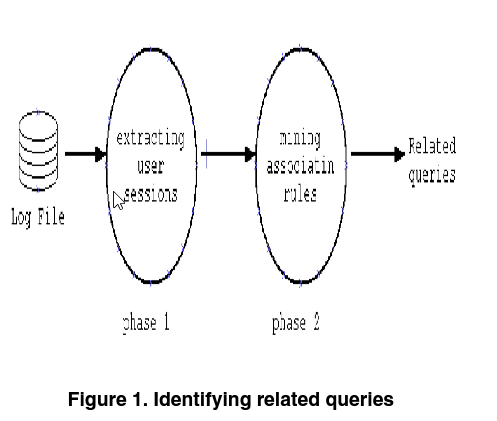

In [17]:
RDD_Column = GenericParser(FILE_PATH).GetColNames()
RDD_Column

['ANONID', 'QUERY', 'QUERYTIME', 'ITEMRANK', 'CLICKURL']

In [18]:
df = GenericParser(FILE_PATH).GetData(RDD_Column).toDF(RDD_Column)
type(df)

pyspark.sql.dataframe.DataFrame

In [19]:
df.show(15)

+------+--------------------+-------------------+--------+--------------------+
|ANONID|               QUERY|          QUERYTIME|ITEMRANK|            CLICKURL|
+------+--------------------+-------------------+--------+--------------------+
|   142|      rentdirect.com|2006-03-01 07:17:12|        |                    |
|   142|www.prescriptionf...|2006-03-12 12:31:06|        |                    |
|   142|          staple.com|2006-03-17 21:19:29|        |                    |
|   142|          staple.com|2006-03-17 21:19:45|        |                    |
|   142|www.newyorklawyer...|2006-03-18 08:02:58|        |                    |
|   142|www.newyorklawyer...|2006-03-18 08:03:09|        |                    |
|   142|     westchester.gov|2006-03-20 03:55:57|       1|http://www.westch...|
|   142|       space.comhttp|2006-03-24 20:51:24|        |                    |
|   142|                dfdf|2006-03-24 22:23:07|        |                    |
|   142|                dfdf|2006-03-24 

In [20]:
df_clean = df.filter("CLICKURL != ''")
df_clean.show(10)

+------+--------------------+-------------------+--------+--------------------+
|ANONID|               QUERY|          QUERYTIME|ITEMRANK|            CLICKURL|
+------+--------------------+-------------------+--------+--------------------+
|   142|     westchester.gov|2006-03-20 03:55:57|       1|http://www.westch...|
|   142|        207 ad2d 530|2006-04-08 01:31:14|       1|http://www.courts...|
|   142|            vera.org|2006-04-08 08:38:42|       1| http://www.vera.org|
|   217|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|
|   217|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|
|   217|      ameriprise.com|2006-03-01 14:06:23|       1|http://www.amerip...|
|   217|          mizuno.com|2006-03-07 22:41:17|       1|http://www.mizuno...|
|   217|asiansexygoddess.com|2006-03-16 14:31:36|       1|http://www.asians...|
|   217|bestasiancompany.com|2006-03-20 15:15:43|       1|http://www.bestas...|
|   217|             lottery|2006-03-27 

In [21]:
df_clean = df_clean.withColumn("_QUERY_TIME_",to_timestamp("QUERYTIME"))
df_clean.show(10)

+------+--------------------+-------------------+--------+--------------------+-------------------+
|ANONID|               QUERY|          QUERYTIME|ITEMRANK|            CLICKURL|       _QUERY_TIME_|
+------+--------------------+-------------------+--------+--------------------+-------------------+
|   142|     westchester.gov|2006-03-20 03:55:57|       1|http://www.westch...|2006-03-20 03:55:57|
|   142|        207 ad2d 530|2006-04-08 01:31:14|       1|http://www.courts...|2006-04-08 01:31:14|
|   142|            vera.org|2006-04-08 08:38:42|       1| http://www.vera.org|2006-04-08 08:38:42|
|   217|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|2006-03-01 11:58:51|
|   217|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|2006-03-01 11:58:51|
|   217|      ameriprise.com|2006-03-01 14:06:23|       1|http://www.amerip...|2006-03-01 14:06:23|
|   217|          mizuno.com|2006-03-07 22:41:17|       1|http://www.mizuno...|2006-03-07 22:41:17|


In [22]:
df_clean.printSchema()

root
 |-- ANONID: string (nullable = true)
 |-- QUERY: string (nullable = true)
 |-- QUERYTIME: string (nullable = true)
 |-- ITEMRANK: string (nullable = true)
 |-- CLICKURL: string (nullable = true)
 |-- _QUERY_TIME_: timestamp (nullable = true)



In [23]:
df_clean.count()

1890568

In [24]:
df_grouped = df_clean.groupBy("ANONID", window("_QUERY_TIME_", "10 minutes")).count()
df_grouped.show(5)

+------+--------------------+-----+
|ANONID|              window|count|
+------+--------------------+-----+
|  2722|{2006-03-23 11:50...|    1|
|  2722|{2006-04-06 07:10...|    1|
|  2722|{2006-05-14 22:50...|    2|
|  2722|{2006-05-25 00:10...|    1|
|  4781|{2006-03-10 12:00...|    1|
+------+--------------------+-----+
only showing top 5 rows



In [25]:
df_grouped.printSchema()

root
 |-- ANONID: string (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- count: long (nullable = false)



In [26]:
df_grouped.count()

976288

In [27]:
df_clean.printSchema()

root
 |-- ANONID: string (nullable = true)
 |-- QUERY: string (nullable = true)
 |-- QUERYTIME: string (nullable = true)
 |-- ITEMRANK: string (nullable = true)
 |-- CLICKURL: string (nullable = true)
 |-- _QUERY_TIME_: timestamp (nullable = true)



In [28]:
df_clean.createOrReplaceTempView("df_clean")
df_grouped.createOrReplaceTempView("df_grouped")

In [29]:
spark.sql('select * from df_clean').show(10)                                     

+------+--------------------+-------------------+--------+--------------------+-------------------+
|ANONID|               QUERY|          QUERYTIME|ITEMRANK|            CLICKURL|       _QUERY_TIME_|
+------+--------------------+-------------------+--------+--------------------+-------------------+
|   142|     westchester.gov|2006-03-20 03:55:57|       1|http://www.westch...|2006-03-20 03:55:57|
|   142|        207 ad2d 530|2006-04-08 01:31:14|       1|http://www.courts...|2006-04-08 01:31:14|
|   142|            vera.org|2006-04-08 08:38:42|       1| http://www.vera.org|2006-04-08 08:38:42|
|   217|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|2006-03-01 11:58:51|
|   217|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|2006-03-01 11:58:51|
|   217|      ameriprise.com|2006-03-01 14:06:23|       1|http://www.amerip...|2006-03-01 14:06:23|
|   217|          mizuno.com|2006-03-07 22:41:17|       1|http://www.mizuno...|2006-03-07 22:41:17|


In [30]:
spark.sql('select * from df_grouped').show(10)

+------+--------------------+-----+
|ANONID|              window|count|
+------+--------------------+-----+
|  2722|{2006-03-23 11:50...|    1|
|  2722|{2006-04-06 07:10...|    1|
|  2722|{2006-05-14 22:50...|    2|
|  2722|{2006-05-25 00:10...|    1|
|  4781|{2006-03-10 12:00...|    1|
|  4781|{2006-04-15 09:50...|    2|
|  4781|{2006-05-09 16:30...|    3|
|  6497|{2006-04-06 01:50...|    1|
|  7005|{2006-04-19 11:10...|    1|
|  8400|{2006-03-11 14:40...|    2|
+------+--------------------+-----+
only showing top 10 rows



In [31]:
df_joined = df_clean.join(df_grouped,((df_clean.ANONID == df_grouped.ANONID) & (df_clean._QUERY_TIME_.between(df_grouped.window.start,df_grouped.window.end))),'left_outer').drop(df_grouped.ANONID)
df_joined.show(10)

+--------------------+-------------------+--------+--------------------+-------------------+------+--------------------+-----+
|               QUERY|          QUERYTIME|ITEMRANK|            CLICKURL|       _QUERY_TIME_|ANONID|              window|count|
+--------------------+-------------------+--------+--------------------+-------------------+------+--------------------+-----+
|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|2006-03-01 11:58:51|   217|{2006-03-01 11:50...|    2|
|             lottery|2006-03-01 11:58:51|       1|http://www.calott...|2006-03-01 11:58:51|   217|{2006-03-01 11:50...|    2|
|      ameriprise.com|2006-03-01 14:06:23|       1|http://www.amerip...|2006-03-01 14:06:23|   217|{2006-03-01 14:00...|    1|
|          mizuno.com|2006-03-07 22:41:17|       1|http://www.mizuno...|2006-03-07 22:41:17|   217|{2006-03-07 22:40...|    1|
|asiansexygoddess.com|2006-03-16 14:31:36|       1|http://www.asians...|2006-03-16 14:31:36|   217|{2006-03-16 

In [32]:
W = df_joined.select("ANONID", df_joined.window.start.cast("string").alias("start"),
                               df_joined.window.end.cast("string").alias("end"),
                               "CLICKURL" )

W = W.select("ANONID",concat(W.start, lit("  "), W.end).alias("Interval"),"CLICKURL")
W = W.dropDuplicates(['ANONID', 'Interval', 'CLICKURL'])
W.show(truncate=False)

+--------+----------------------------------------+-------------------------------------+
|ANONID  |Interval                                |CLICKURL                             |
+--------+----------------------------------------+-------------------------------------+
|10086493|2006-04-15 14:20:00  2006-04-15 14:30:00|http://www.vivalasvegas.net          |
|10092929|2006-05-20 14:30:00  2006-05-20 14:40:00|http://tulsa.citysearch.com          |
|10118130|2006-03-22 18:00:00  2006-03-22 18:10:00|http://www.thebridalshop.com         |
|10379069|2006-03-14 14:20:00  2006-03-14 14:30:00|http://www.canismajor.com            |
|1040180 |2006-05-19 18:30:00  2006-05-19 18:40:00|http://www.therealblackwallstreet.com|
|10476622|2006-05-05 17:40:00  2006-05-05 17:50:00|http://www.tastycrockpotrecipes.net  |
|10493820|2006-05-05 10:40:00  2006-05-05 10:50:00|http://www.geocities.com             |
|10587982|2006-04-24 20:50:00  2006-04-24 21:00:00|http://www.classicthemes.com         |
|10665849|

In [33]:
W.count()

1673888

In [34]:
# Random Sample 5% of a data, in order to make the calculations easier
W = W.repartition(1000)
W = W.sample(0.05)

In [35]:
W.count()

83714

In [36]:
grouped_sessions = W.groupBy('ANONID','Interval').agg(collect_list('CLICKURL').alias('items'))
grouped_sessions.show(5)

+--------+--------------------+--------------------+
|  ANONID|            Interval|               items|
+--------+--------------------+--------------------+
|10003003|2006-03-24 12:40:...|[http://www.funbe...|
| 1000335|2006-05-06 14:20:...|[http://www.geapp...|
|10006516|2006-05-30 12:20:...|[http://www.dogge...|
|10006516|2006-05-31 12:50:...|[http://www.woodf...|
| 1002092|2006-03-02 09:20:...|[http://www.chero...|
+--------+--------------------+--------------------+
only showing top 5 rows



In [37]:
grouped_sessions = grouped_sessions.withColumn('array_size',size(col('items')))
grouped_sessions.show(10)

+--------+--------------------+--------------------+----------+
|  ANONID|            Interval|               items|array_size|
+--------+--------------------+--------------------+----------+
|10003003|2006-03-24 12:40:...|[http://www.funbe...|         1|
| 1000335|2006-05-06 14:20:...|[http://www.geapp...|         1|
|10006516|2006-05-30 12:20:...|[http://www.dogge...|         1|
|10006516|2006-05-31 12:50:...|[http://www.woodf...|         1|
| 1002092|2006-03-02 09:20:...|[http://www.chero...|         1|
| 1002092|2006-03-23 16:00:...|[http://www.2mcct...|         1|
|  100218|2006-03-19 18:10:...|[http://www.maine...|         1|
| 1002425|2006-03-03 21:20:...|[http://www.usna6...|         1|
|10032487|2006-04-16 15:50:...|[http://www.smpla...|         1|
|10041567|2006-05-09 22:00:...|[http://www.autom...|         1|
+--------+--------------------+--------------------+----------+
only showing top 10 rows



In [38]:
grouped_sessions = grouped_sessions.select(concat(grouped_sessions.ANONID,lit(":  "),grouped_sessions.Interval).alias("Session"),"items",'array_size')
grouped_sessions.show(truncate=False)

+---------------------------------------------------+---------------------------------------------------------------------------------------+----------+
|Session                                            |items                                                                                  |array_size|
+---------------------------------------------------+---------------------------------------------------------------------------------------+----------+
|10003003:  2006-03-24 12:40:00  2006-03-24 12:50:00|[http://www.funbeaches.com]                                                            |1         |
|1000335:  2006-05-06 14:20:00  2006-05-06 14:30:00 |[http://www.geappliances.com]                                                          |1         |
|10006516:  2006-05-30 12:20:00  2006-05-30 12:30:00|[http://www.doggear.net]                                                               |1         |
|10006516:  2006-05-31 12:50:00  2006-05-31 13:00:00|[http://www.woodfinder.com]  

In [39]:
#Check partitions
print("partition count before:"+str(grouped_sessions.rdd.getNumPartitions()))
grouped_sessions = grouped_sessions.repartition(1000)
print("partition count after:"+str(grouped_sessions.rdd.getNumPartitions()))

partition count before:11
partition count after:1000


In [40]:
grouped_sessions2 = grouped_sessions.orderBy(col('array_size').desc())
grouped_sessions2.show()

+--------------------+--------------------+----------+
|             Session|               items|array_size|
+--------------------+--------------------+----------+
|231996:  2006-05-...|[http://web2.acbl...|         4|
|2209786:  2006-04...|[http://smokinjoe...|         4|
|2640513:  2006-03...|[http://crunch.co...|         4|
|3571966:  2006-03...|[http://www.blog....|         4|
|5469375:  2006-03...|[http://xt71sexto...|         4|
|6057762:  2006-05...|[http://en.wikipe...|         4|
|12416292:  2006-0...|[http://www.aquad...|         4|
|576123:  2006-03-...|[http://www.theor...|         4|
|9894316:  2006-05...|[http://www.drago...|         4|
|3241737:  2006-04...|[http://people.ha...|         4|
|2814361:  2006-03...|[http://www.vh1.c...|         4|
|2745361:  2006-05...|[http://www.latex...|         4|
|8300133:  2006-03...|[http://www.eye.n...|         4|
|3620882:  2006-03...|[http://www.ltsa....|         4|
|2325679:  2006-03...|[http://www.cervi...|         4|
|1544433: 

### Association rule mining

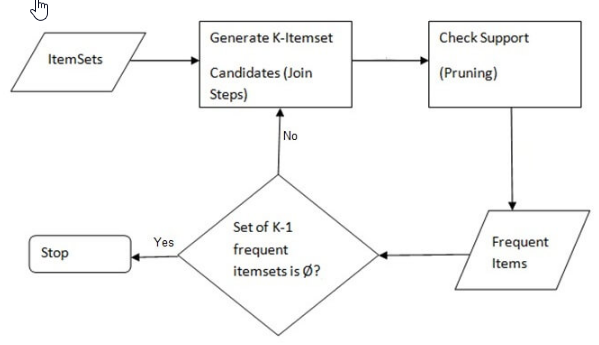

In [58]:
def create_possible_combinations(all_items, k):
    # This functions gets a list of items and k, and returns all possible k-item combinations.
    # all_items --> <list>
    # k         --> <int>
    res_tmp = set([])
    for subset in itertools.combinations(all_items, k):       
       res_tmp.add((subset))

    res_lst = list(res_tmp)
    result = [list(res_lst[i]) for i in range(len(res_lst))]

    return result


def build_support(sessions_data, items, min_support, max_support):

    # sessions_data --> <DataFrame> Name of dataset contain sessions
    # items         --> <ArrayType(StringType())> Column name that contain items
    # min_support   --> <float> between 0 and 1
    # max_support   --> <float> between 0 and 1  

    # Sort item set
    data = sessions_data.select(items,sort_array(items,asc=True).alias('array'))

    # Create F1 + Filter by min support:
    F1 = (data.withColumn("explode", F.explode("array"))
          .groupBy("explode")
          .count()
          .orderBy(F.desc("count"))).filter(col('count')>=min_support).filter(col('count')<=max_support)

    # Create all possible item combinations
    lst = [str(i.explode) for i in F1.select("explode").collect()]


    # Create an empty DataFrame
    emp_RDD = spark.sparkContext.emptyRDD()
    columns1 = StructType([StructField('Item', ArrayType(StringType()), False),
                          StructField('Support', LongType(), False)])
    Support = spark.createDataFrame(data=emp_RDD,
                                            schema=columns1)
    
    Support = Support.repartition(1000)
    sessions_data = sessions_data.repartition(5000)


    # # Create Support for 2 and 3 itemsets
    for k in range(2,4):
        combinations = create_possible_combinations(lst,k)
        for j in range(len(combinations)):
            # print(combinations[j])
            row = sorted(combinations[j])  
            # print(row)               
            res = sessions_data.withColumn("NewColumn", F.array([F.lit(x) for x in row]))         
            res = res.select(items,'NewColumn', size(array_intersect(res.items, res.NewColumn)).alias('Intersect'))  #<-- res.items is not generic
            res = res.filter(col('Intersect')>=k).count()
            # # res.show()
            columns = ['Item','Support']
            newRow = spark.createDataFrame([(row, res)], columns)
            Support = Support.union(newRow).filter(col('Support')>=min_support).filter(col('Support')<=max_support)


    return Support
    # return F1
  


def association_rule_mining(support_table, confidence):

    cross = support_table.select('Item').withColumnRenamed('Item', 'Item1')\
          .crossJoin(support_table.select('Item').withColumnRenamed('Item', 'Item2'))\
          .filter(col('Item1')!=col('Item2'))
    cross2 = cross.select('*', sort_array(array_union(col('Item1'),col('Item2'))).alias('X'))
    cross3 = cross2.join(support_table, on=[cross2.X==support_table.Item], how = 'left').drop(col('Item')).withColumnRenamed('Support', 'Support(X)')
    cross4 = cross3.join(support_table, on=[cross3.Item1==support_table.Item], how = 'left').drop(col('Item')).withColumnRenamed('Support', 'Support(Y)')
    cross5 = cross4.filter(col('Support(X)').isNotNull() & col('Support(Y)').isNotNull())
    cross6 = cross5.select('*', (col('Support(X)')/col('Support(Y)')).alias('Confidence')).orderBy(col('Confidence').desc())
    cross7 = cross6.withColumn("rule1",concat_ws(",",col("Item1"))).withColumn("rule2",concat_ws(",",col("Item2")))
    cross8 = cross7.select('*', concat(lit('{'), cross7.rule1, lit('} ==> {'), cross7.rule2, lit('}')).alias('Rule')).drop(col('rule1')).drop(col('rule2'))
    cross9 = cross8.filter(col('confidence')>=confidence)

    return cross9.select('Rule','Confidence')


In [64]:
# Support building
support = build_support(grouped_sessions, 'items',40, 50)
support.show()

In [59]:
# Rule mining
rules = association_rule_mining(support, 0.0)
rules.show()
